# Imports


In [1]:
!nvidia-smi

Sat Jan 18 16:14:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm




In [3]:
# # COMMENT AFTER USE TO AVOID HASSLE ; )
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Data Loading

In [113]:
truth_src = "/content/b3/truth.jsonl"
truth_data = []
with open(truth_src,encoding="utf8") as f:
    cnt = 0
    for line in f:
        truth_data.append(json.loads(line))

In [114]:
target_src = "/content/b3/instances.jsonl"
target_data = []
with open(target_src,encoding="utf8") as f:
    cnt = 0
    for line in f:
        target_data.append(json.loads(line))

In [115]:
truth_data_df = pd.DataFrame(truth_data)
target_data_df = pd.DataFrame(target_data)

In [116]:
final_data= pd.DataFrame()

In [117]:
final_data['target_id'] = target_data_df['id']
final_data['truth_id'] = truth_data_df['id']
final_data['target_title'] = target_data_df['targetTitle']
final_data['target_desc'] = target_data_df['targetDescription']
final_data['target_keywords'] = target_data_df['targetKeywords']
final_data['truth_mean'] = truth_data_df['truthMean']
final_data['truth_mode'] = truth_data_df['truthMode']
final_data['truth_median'] = truth_data_df['truthMedian']
final_data['truth_class'] = truth_data_df['truthClass']

## Adding more data (due to data being split into multiple files)

In [118]:
# MORE DATA
truth_src = "/content/b2/truth.jsonl"
more_truth_data = []
with open(truth_src,encoding="utf8") as f:
    cnt = 0
    for line in f:
        more_truth_data.append(json.loads(line))


In [119]:
target_src = "/content/b2/instances.jsonl"
more_target_data = []
with open(target_src,encoding="utf8") as f:
    cnt = 0
    for line in f:
        more_target_data.append(json.loads(line))

In [120]:
more_truth_data_df = pd.DataFrame(more_truth_data)
more_target_data_df = pd.DataFrame(more_target_data)

In [121]:
more_final_data= pd.DataFrame()

more_final_data['target_id'] = more_target_data_df['id']
more_final_data['truth_id'] = more_truth_data_df['id']
more_final_data['target_title'] = more_target_data_df['targetTitle']
more_final_data['target_desc'] = more_target_data_df['targetDescription']
more_final_data['target_keywords'] = more_target_data_df['targetKeywords']
more_final_data['truth_mean'] = more_truth_data_df['truthMean']
more_final_data['truth_mode'] = more_truth_data_df['truthMode']
more_final_data['truth_median'] = more_truth_data_df['truthMedian']
more_final_data['truth_class'] = more_truth_data_df['truthClass']

In [122]:
more_final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target_id        19538 non-null  object 
 1   truth_id         19538 non-null  object 
 2   target_title     19538 non-null  object 
 3   target_desc      19538 non-null  object 
 4   target_keywords  19538 non-null  object 
 5   truth_mean       19538 non-null  float64
 6   truth_mode       19538 non-null  float64
 7   truth_median     19538 non-null  float64
 8   truth_class      19538 non-null  object 
dtypes: float64(3), object(6)
memory usage: 1.3+ MB


In [123]:
# Combined date frame
final_data = pd.concat([final_data,more_final_data],ignore_index=True)

## EDA

In [124]:
final_data.info()
final_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38517 entries, 0 to 38516
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target_id        38517 non-null  object 
 1   truth_id         38517 non-null  object 
 2   target_title     38517 non-null  object 
 3   target_desc      38517 non-null  object 
 4   target_keywords  38517 non-null  object 
 5   truth_mean       38517 non-null  float64
 6   truth_mode       38517 non-null  float64
 7   truth_median     38517 non-null  float64
 8   truth_class      38517 non-null  object 
dtypes: float64(3), object(6)
memory usage: 2.6+ MB


,truth_mean,truth_mode,truth_median
count,38517.000000,38517.000000,38517.000000
mean,0.308799,0.263044,0.269812
std,0.262504,0.360209,0.336165
min,0.000000,0.000000,0.000000
25%,0.066667,0.000000,0.000000
50%,0.266667,0.000000,0.000000
75%,0.466667,0.333333,0.333333
max,1.000000,1.000000,1.000000


In [125]:
final_data['title_word_count'] = final_data['target_title'].apply(lambda x: len(x.split()))

In [126]:
final_data['title_word_count'].describe()

,title_word_count
count,38517.000000
mean,11.585715
std,6.074079
min,1.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,405.000000


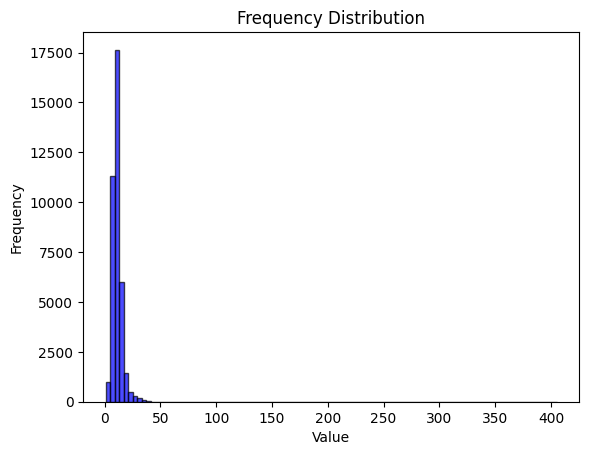

In [127]:
plt.hist(final_data['title_word_count'], bins=100, color='blue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Frequency Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Processing text data

In [132]:
# Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = ' '.join(text.split())
    return text

# Tokenizing

In [133]:
print("Loading transformer model...")
tokenizer = AutoTokenizer.from_pretrained("caush/Clickbait1",is_split_into_words=True)
model = AutoModel.from_pretrained("caush/Clickbait1",output_hidden_states=True,output_attentions=True)
print("Transformer model loaded")

def get_embeddings(texts, tokenizer, model, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True,
                         max_length=256,  # Increased max_length
                         return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Use attention-weighted mean pooling
            attention_mask = inputs['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

            cls_embedding = token_embeddings[:, 0, :]
            mean_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

            final_embedding = (cls_embedding + mean_embedding) / 2
            embeddings.extend(final_embedding.cpu().numpy())

        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return np.array(embeddings)

Loading transformer model...
Transformer model loaded


### Train with feature engineering

In [134]:
# print("Preparing text data...")
# final_data['combined_text'] = final_data.apply(
#     lambda x: f"Title: {preprocess_text(x['target_title'])} Keywords: {preprocess_text(x['target_keywords'])} Description: {preprocess_text(x['target_desc'])}",
#     axis=1
# )

### Train with only titles

In [135]:
# Title only
print("Preparing text data...")
final_data['combined_text'] = final_data.apply(
    lambda x: f"{preprocess_text(x['target_title'])}",
    axis=1
)

Preparing text data...


In [136]:
print("Generating embeddings...")
# We are using combined text which is combination of 3 features.
X = get_embeddings(
    final_data['combined_text'].tolist(),
    tokenizer,
    model
)
# Note: Label of the weighted sum of all the truth value for better understanding and removing bias
y = ((2*final_data['truth_mode']+final_data['truth_median']+0.1*final_data['truth_mean'])/3.1).values
print("embeddings generated")

Generating embeddings...


Generating embeddings: 100%|██████████| 2408/2408 [00:55<00:00, 43.69it/s]


embeddings generated


In [200]:
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 8. Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import pickle
with open('new_scaler.pkl','wb') as f:
    pickle.dump(scaler, f)


print("Features are ready to train!")

Splitting data...
Scaling features...
Features are ready to train!


# Model Training

##1. Model Architecture

In [138]:
def create_model():
    model = models.Sequential([
        layers.Dense(384, activation='relu', input_shape=(384,)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='sigmoid'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])

    initial_learning_rate = 0.000005
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

    model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=['mae'])
    return model

In [139]:
NN_model = create_model()
NN_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 384)                 │         147,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,729 (795.82 KB)

 Trainable params: 202,625 (791.50 KB)

 Non-trainable params: 1,104 (4.31 KB)

##2. Training the model

In [140]:
history = NN_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.15,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=12,
            min_lr=0.0000001
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 2.0582 - mae: 1.1639 - val_loss: 1.8443 - val_mae: 1.2242 - learning_rate: 5.0000e-06
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8864 - mae: 0.7572 - val_loss: 0.5868 - val_mae: 0.6245 - learning_rate: 5.0000e-06
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6198 - mae: 0.6271 - val_loss: 0.4167 - val_mae: 0.5154 - learning_rate: 5.0000e-06
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4797 - mae: 0.5504 - val_loss: 0.3509 - val_mae: 0.4665 - learning_rate: 5.0000e-06
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4152 - mae: 0.5084 - val_loss: 0.3000 - val_mae: 0.4241 - learning_rate: 5.0000e-06
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3469 - mae: 0.4601 - val_loss: 0.2741 - val_mae: 0.3987 - learning_rate: 5.0000e-06
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3046 - mae: 0.4300 - val_loss: 0.2413 - val_mae: 0.3656 - le

In [142]:
NN_model.save('NN_model_title_moredata.keras')

## Assessing the testing

In [143]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # LOSS
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()

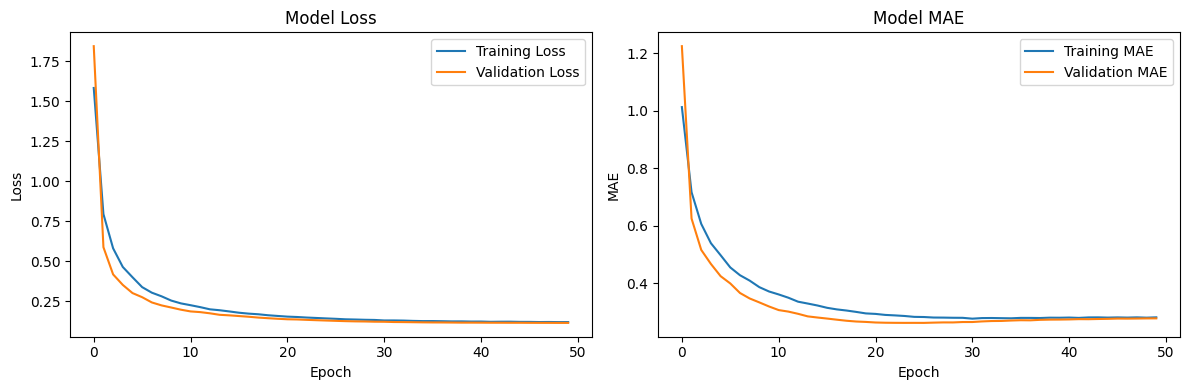

In [144]:
plot_training_history(history)

## Validation

In [145]:
def evaluate_model_new(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()

    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    return mse, mae


In [146]:
mse, mae = evaluate_model_new(NN_model, X_test, y_test)

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error (MSE): 0.1161
Mean Absolute Error (MAE): 0.2789


##3. Testing the model

## Loading the testing data

In [147]:
truth_src = "/content/b1/truth.jsonl"
test_truth_data = []
with open(truth_src,encoding="utf8") as f:
    cnt = 0
    for line in f:
        test_truth_data.append(json.loads(line))

In [148]:
target_src = "/content/b1/instances.jsonl"
test_target_data = []
with open(target_src,encoding="utf8") as f:
    cnt = 0
    for line in f:
        test_target_data.append(json.loads(line))

In [149]:
test_truth_data_df = pd.DataFrame(test_truth_data)
test_target_data_df = pd.DataFrame(test_target_data)

In [150]:
test_data= pd.DataFrame()

test_data['target_id'] = test_target_data_df['id']
test_data['truth_id'] = test_truth_data_df['id']
test_data['target_title'] = test_target_data_df['targetTitle']
test_data['target_desc'] = test_target_data_df['targetDescription']
test_data['target_keywords'] = test_target_data_df['targetKeywords']
test_data['truth_mean'] = test_truth_data_df['truthMean']
test_data['truth_mode'] = test_truth_data_df['truthMode']
test_data['truth_median'] = test_truth_data_df['truthMedian']
test_data['truth_class'] = test_truth_data_df['truthClass']

In [151]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target_id        2459 non-null   object 
 1   truth_id         2459 non-null   object 
 2   target_title     2459 non-null   object 
 3   target_desc      2459 non-null   object 
 4   target_keywords  2459 non-null   object 
 5   truth_mean       2459 non-null   float64
 6   truth_mode       2459 non-null   float64
 7   truth_median     2459 non-null   float64
 8   truth_class      2459 non-null   object 
dtypes: float64(3), object(6)
memory usage: 173.0+ KB


## Generating the embeddings

In [42]:
# print("Preparing test text data...")
# test_data['combined_text'] = test_data.apply(
#     lambda x: f"Title: {preprocess_text(x['target_title'])} Keywords: {preprocess_text(x['target_keywords'])} Description: {preprocess_text(x['target_desc'])}",
#     axis=1
# )

Preparing test text data...


In [152]:
# Title only
print("Preparing text data...")
test_data['combined_text'] = test_data.apply(
    lambda x: f"{preprocess_text(x['target_title'])}",
    axis=1
)

Preparing text data...


In [153]:
print("Generating test embeddings...")
# We are using combined text which is combination of 3 features.
test_X = get_embeddings(
    test_data['combined_text'].tolist(),
    tokenizer,
    model
)
# Note: Label of the weighted sum of all the truth value for better understanding and removing bias
test_y = ((2*test_data['truth_mode']+test_data['truth_median']+0.1*test_data['truth_mean'])/3.1).values
print("test embeddings generated")

Generating test embeddings...


Generating embeddings: 100%|██████████| 154/154 [00:11<00:00, 13.37it/s]


test embeddings generated


In [154]:
# 8. For scikit learn
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
test_X_scaled = scaler.transform(test_X)

print("Features are ready to test!")

Scaling features...
Features are ready to test!


In [155]:
# Loading the trained Model

In [ ]:
latest_model = keras.models.load_model('NN_latest_2.keras')
latest_model.summary()

In [156]:
#1 Deviation based

In [157]:
def evaluate_model(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()  # Flatten predictions to match y_test shape

    mse = mean_squared_error(y_test, y_pred)

    # Calculate accuracy within a margin of error
    threshold = 0.5
    accuracy = np.mean(np.abs(y_test - y_pred) < threshold)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Accuracy (within {threshold} threshold): {accuracy:.4f}")

    return mse, accuracy

In [158]:
latest_model = NN_model

In [159]:
mse, accuracy = evaluate_model(latest_model, test_X, test_y)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error: 0.0968
Accuracy (within 0.5 threshold): 0.8890


In [ ]:
#2 Mse and Mae based

In [160]:
def evaluate_model_new(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()  # Flatten predictions to match y_test shape

    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    return mse, mae

In [161]:
mse, mae = evaluate_model_new(latest_model, test_X, test_y)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.0968
Mean Absolute Error (MAE): 0.2565


# Trying out scikit learn models

### SGDRegressor

In [162]:
sgd_regressor = SGDRegressor(
    max_iter=1000000, alpha=0.1, learning_rate='invscaling', random_state=42)

In [170]:
sgd_regressor.fit(X_train_scaled, y_train)
y_pred = sgd_regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test,y_pred)
mse

0.1304753197479651

In [199]:
import pickle

# saving the trained model for use in Frontend
with open('sgd_regressor.pkl','wb') as f:
    pickle.dump(sgd_regressor,f)

### xgboost

In [165]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)

mse=mean_squared_error(y_test, y_pred)
mse

0.12565024982060222

### Testing Other models

In [166]:
def evaluate_regressor(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Model: {type(model).__name__}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")


    return mse, mae

In [167]:
test_X_scaled = scaler.transform(test_X)

In [174]:
# loading the regressor model
with open('sgd_regressor.pkl', 'rb') as f:
    new_regressor = pickle.load(f)

In [175]:
evaluate_regressor(sgd_regressor, test_X_scaled, test_y)
evaluate_regressor(new_regressor, test_X_scaled, test_y)
evaluate_regressor(xgb_model, test_X_scaled, test_y)

Model: SGDRegressor
Mean Squared Error (MSE): 0.0941
Mean Absolute Error (MAE): 0.2381
Model: SGDRegressor
Mean Squared Error (MSE): 0.0941
Mean Absolute Error (MAE): 0.2381
Model: XGBRegressor
Mean Squared Error (MSE): 0.1243
Mean Absolute Error (MAE): 0.2819


(0.12425339438859988, 0.2818932027549688)

# For new single exmples testing

In [203]:
def get_score_regressor(transformer_model,tokenizer,text):
    X_sample = get_embeddings([text], tokenizer, transformer_model)

    sample_input = X_sample  # or any other input vector of shape (384,)

    with open('new_scaler.pkl','rb') as f:
      print("Loading scaler")
      sc = pickle.load(f)
      print("Scaler loaded")
    sample_input=sc.transform(sample_input)

    with open('sgd_regressor.pkl', 'rb') as f:
      new_regressor = pickle.load(f)
    predicted_value = new_regressor.predict(sample_input)
    return predicted_value[0]

In [207]:
get_score_regressor(model,tokenizer,"Best ways to make money they don't want you to know")

Generating embeddings: 100%|██████████| 1/1 [00:00<00:00, 45.26it/s]

Loading scaler
Scaler loaded


0.9385765866010924